In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import nd2
import numpy as np
import os

In [28]:
path = '..\data\iScat\Data\\2024_11_11\\Metasurface\\Chip_02\\Metasurface 01\\Brightfield'
z_stack_path = path+'\\02_01_BF.nd2'
f1_path = path+'\\Captured Cy5.tif'
f2_path = path+'\\Captured FITC.tif'
f3_path = path+'\\Captured TRITC.tif'
f1_results = path+"\\Cy5.csv"
f2_results = path+"\\FITC.csv"
f3_results = path+"\\TRITC.csv"
z_stack_image = nd2.imread(z_stack_path)
f1_img =  Image.open(f1_path)
f2_img =  Image.open(f2_path)
f3_img =  Image.open(f3_path)

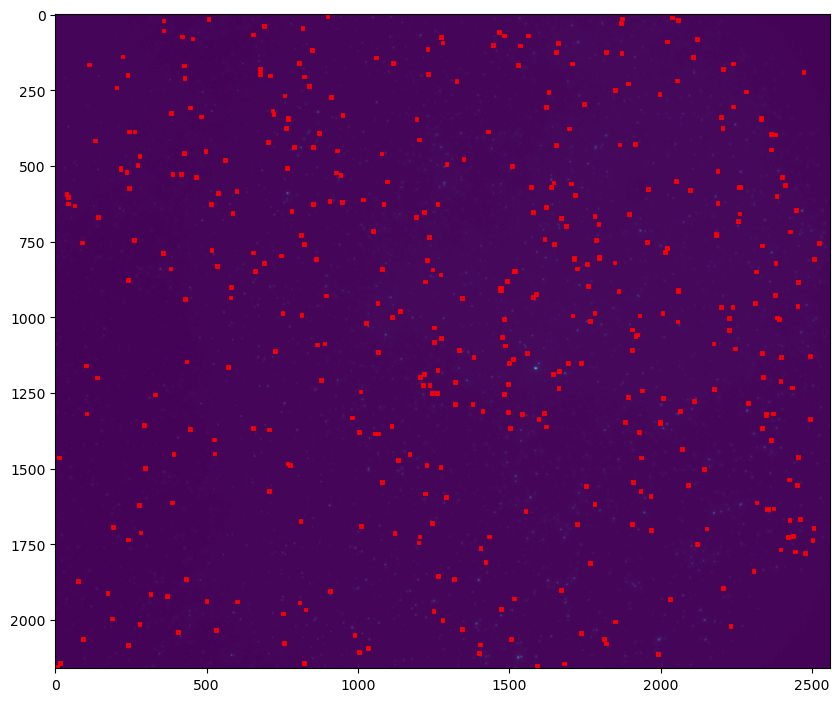

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the CSV file
csv_file = f2_results
data = pd.read_csv(csv_file)

# Load your image
image_path = f1_path  # Replace with your image path
image = plt.imread(image_path)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# Iterate over rows in the CSV and draw rectangles
for index, row in data.iterrows():
    x_min, y_min, x_max, y_max = row['xMin'], row['yMin'], row['xMax'], row['yMax']
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import draw
from typing import List, Tuple
from matplotlib.colors import ListedColormap

def create_segmentation_mask(csv_files: List[str], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Create a simplified segmentation mask from multiple CSV files of particle detections.
    
    Parameters:
    -----------
    csv_files : List[str]
        List of paths to CSV files containing particle detection data
    image_shape : Tuple[int, int]
        Shape of the output segmentation mask (height, width)
    
    Returns:
    --------
    np.ndarray
        Segmentation mask with simplified labels:
        0 - Background
        1 - Individual particles
        2 - Superposed particles
    """
    # Initialize the segmentation mask
    segmentation_mask = np.zeros(image_shape, dtype=np.int16)
    
    # Process each CSV file
    for csv_file in csv_files:
        # Read the CSV file
        df = pd.read_csv(csv_file)
        
        # Process each particle detection
        for _, row in df.iterrows():
            # Extract rectangle coordinates
            xmin, ymin = int(row['xMin']), int(row['yMin'])
            xmax, ymax = int(row['xMax']), int(row['yMax'])
            
            # Extract centroid coordinates
            x_center, y_center = int(row['X_(px)']), int(row['Y_(px)'])
            
            # Create an ellipse mask within the rectangle
            height = ymax - ymin + 1
            width = xmax - xmin + 1
            
            # Create meshgrid for the rectangle region
            xx, yy = np.meshgrid(
                np.arange(xmin, xmax + 1), 
                np.arange(ymin, ymax + 1)
            )
            
            # Compute ellipse mask
            ellipse_mask = ((xx - x_center)**2 / ((width/2)**2) + 
                            (yy - y_center)**2 / ((height/2)**2)) <= 1
            
            # Get coordinates of pixels inside the ellipse
            ellipse_coords = np.column_stack([yy[ellipse_mask], xx[ellipse_mask]])
            
            # Check for existing particles in the region
            existing_particles = np.unique(segmentation_mask[ellipse_coords[:, 0], ellipse_coords[:, 1]])
            existing_particles = existing_particles[existing_particles != 0]
            
            if len(existing_particles) > 0:
                # Superposed particles
                segmentation_mask[ellipse_coords[:, 0], ellipse_coords[:, 1]] = 2
                
                # Mark existing particles as superposed
                segmentation_mask[segmentation_mask != 0] = 2
            else:
                # New individual particle
                segmentation_mask[ellipse_coords[:, 0], ellipse_coords[:, 1]] = 1
    
    return segmentation_mask

def visualize_segmentation(segmentation_mask: np.ndarray, crop_size: int = 244):
    """
    Visualize a cropped region of the segmentation mask.
    
    Parameters:
    -----------
    segmentation_mask : np.ndarray
        Segmentation mask to visualize
    crop_size : int, optional
        Size of the square crop (default 244x244)
    """
    # Determine center crop
    h, w = segmentation_mask.shape
    start_h = (h - crop_size) // 2
    start_w = (w - crop_size) // 2
    
    # Crop the segmentation mask
    cropped_mask = segmentation_mask[
        start_h:start_h+crop_size, 
        start_w:start_w+crop_size
    ]
    
    plt.figure(figsize=(10, 10))
    
    # Create a custom colormap
    
    cmap = ListedColormap(['black', 'blue', 'red'])
    
    plt.imshow(cropped_mask, cmap=cmap, interpolation='nearest')
    plt.colorbar(ticks=[0, 1, 2], 
                 label='Particle Labels',
                 drawedges=True)
    plt.title(f'{crop_size}x{crop_size} Particle Segmentation Mask')
    plt.tight_layout()
    plt.show()


In [35]:
a= np.array([[1, 1, 0, 0, 0]])
np.unique(a)

array([0, 1])

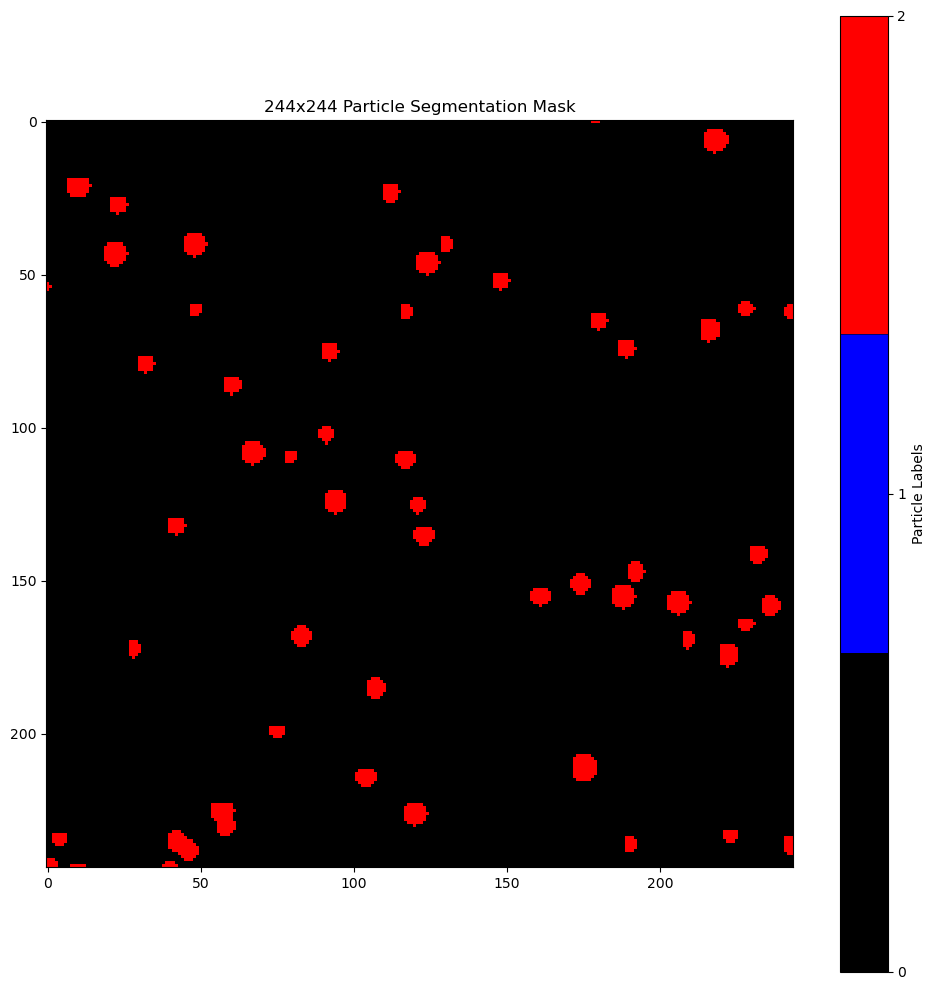

Segmentation mask statistics:
Background pixels: 5405257
Individual particle 1 pixels: 132
Superposed particle region pixels: 124211


In [40]:
csv_files = [f1_results, f2_results, f3_results]

image_shape = z_stack_image.shape[1:]

# Create segmentation mask
segmentation_mask = create_segmentation_mask(csv_files, image_shape)

# Visualize the segmentation
visualize_segmentation(segmentation_mask)
unique, counts = np.unique(segmentation_mask, return_counts=True)
print("Segmentation mask statistics:")
for label, count in zip(unique, counts):
    if label == 0:
        print(f"Background pixels: {count}")
    elif label == 2:
        print(f"Superposed particle region pixels: {count}")
    else:
        print(f"Individual particle {label} pixels: {count}")


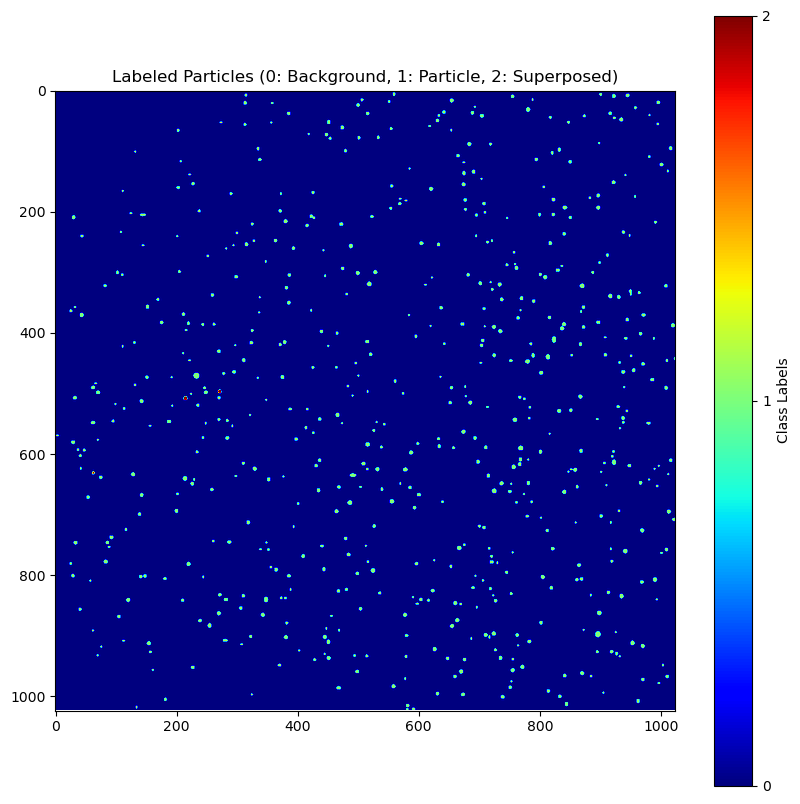

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example CSV file paths
csv_files = [f1_results, f2_results, f3_results]

# Example image shape (replace with the actual fluorescence image dimensions)
image_shape = z_stack_image.shape[1:]  # Replace with actual shape from fluorescence image
canvas_height, canvas_width = image_shape

def label_particles_from_csv(csv_file, width, height):
    """
    Labels pixels for a single channel based on ellipse positions in the CSV.
    """
    data = pd.read_csv(csv_file)
    labels = np.zeros((height, width), dtype=np.uint8)  # Background as 0

    # Iterate over all rows in the data
    for _, row in data.iterrows():
        x_centroid = row['X_(px)']
        y_centroid = row['Y_(px)']
        x_min = row['xMin']
        y_min = row['yMin']
        x_max = row['xMax']
        y_max = row['yMax']

        # Calculate ellipse parameters
        a = (x_max - x_min) / 2  # Semi-major axis
        b = (y_max - y_min) / 2  # Semi-minor axis
        center_x = x_centroid
        center_y = y_centroid

        # Generate grid of pixels within the bounding rectangle
        x_range = np.arange(max(0, int(x_min)), min(width, int(x_max) + 1))
        y_range = np.arange(max(0, int(y_min)), min(height, int(y_max) + 1))
        xx, yy = np.meshgrid(x_range, y_range)

        # Ellipse equation: ((x - center_x)^2 / a^2) + ((y - center_y)^2 / b^2) <= 1
        ellipse_mask = ((xx - center_x) ** 2) / (a ** 2) + ((yy - center_y) ** 2) / (b ** 2) <= 1

        # Label pixels inside the ellipse
        for i in range(ellipse_mask.shape[0]):
            for j in range(ellipse_mask.shape[1]):
                if ellipse_mask[i, j]:
                    x, y = x_range[j], y_range[i]
                    labels[y, x] = 1  # Mark as particle
    return labels

# Combine labels from all CSV files
final_labels = np.zeros((canvas_height, canvas_width), dtype=np.uint8)  # Background as 0

for csv_file in csv_files:
    channel_labels = label_particles_from_csv(csv_file, canvas_width, canvas_height)
    # Update final labels: handle overlaps
    final_labels = np.where((final_labels == 1) & (channel_labels == 1), 2, final_labels)  # Overlap -> 2
    final_labels = np.maximum(final_labels, channel_labels)  # Update with new channel labels

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(final_labels[:1024,:1024], cmap='jet', interpolation='lanczos')
plt.colorbar(ticks=[0, 1, 2], label="Class Labels")
plt.title("Labeled Particles (0: Background, 1: Particle, 2: Superposed)")
plt.show()

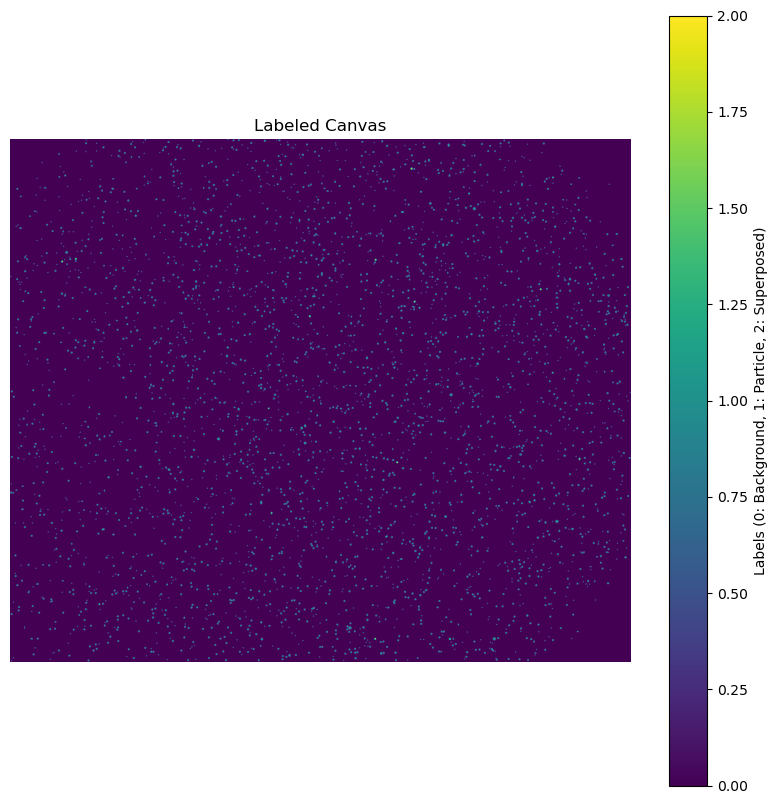

In [75]:
import numpy as np
import cv2

def label_particles(image_shape, csv_files):
    """
    Labels a canvas based on particle data from CSV files.
    
    Args:
        image_shape (tuple): Shape of the fluorescence image (height, width).
        csv_files (list of str): Paths to CSV files with particle positions.
    
    Returns:
        np.ndarray: Labeled canvas with classes:
                    0 - Background
                    1 - Particle
                    2 - Superposed Particle
    """
    # Initialize the canvas
    label_canvas = np.zeros(image_shape, dtype=np.uint8)
    
    for csv_file in csv_files:
        # Load particle data
        particle_data = pd.read_csv(csv_file)
        
        for _, row in particle_data.iterrows():
            # Extract bounding rectangle and compute ellipse center
            x_min, y_min = row['xMin'], row['yMin']
            x_max, y_max = row['xMax'], row['yMax']
            center_x = int((x_min + x_max) / 2)
            center_y = int((y_min + y_max) / 2)
            
            # Compute ellipse axes
            axes_x = int((x_max - x_min) / 2)
            axes_y = int((y_max - y_min) / 2)
            
            # Draw the ellipse on a temporary canvas
            temp_canvas = np.zeros_like(label_canvas)
            cv2.ellipse(
                temp_canvas,
                (center_x, center_y),
                (axes_x, axes_y),
                0, 0, 360, 1, -1
            )
            
            # Identify overlapping regions
            overlap = (label_canvas == 1) & (temp_canvas == 1)
            label_canvas[overlap] = 2
            
            # Add non-overlapping regions
            label_canvas[(label_canvas == 0) & (temp_canvas == 1)] = 1
    
    return label_canvas


def visualize_labeled_canvas(z_stack_image, csv_files):
    """
    Labels particles on a canvas and visualizes the result.

    Args:
        z_stack_image (np.ndarray): The fluorescence image stack.
        csv_files (list of str): Paths to CSV files with particle positions.
    
    Returns:
        np.ndarray: Labeled canvas with classes:
                    0 - Background
                    1 - Particle
                    2 - Superposed Particle
    """
    # Get the shape of the canvas
    image_shape = z_stack_image.shape[1:]
    
    # Generate the labeled canvas
    labeled_canvas = label_particles(image_shape, csv_files)
    
    # Plot the labeled canvas
    plt.figure(figsize=(10, 10))
    plt.title("Labeled Canvas")
    plt.imshow(labeled_canvas, cmap='viridis')
    plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
    plt.axis('off')
    plt.show()
    
    return labeled_canvas

# Simulating a fluorescence image stack (dummy data for visualization)

csv_files = [f1_results, f2_results, f3_results]
labeled_canvas_visual = visualize_labeled_canvas(z_stack_image, csv_files)

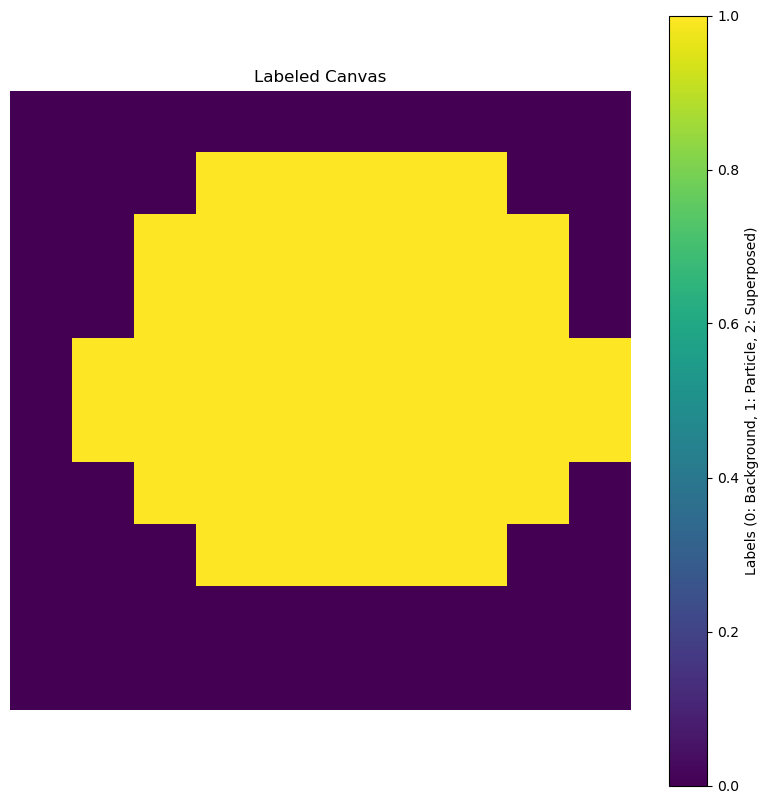

In [98]:
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(labeled_canvas_visual[580:590,510:520] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()

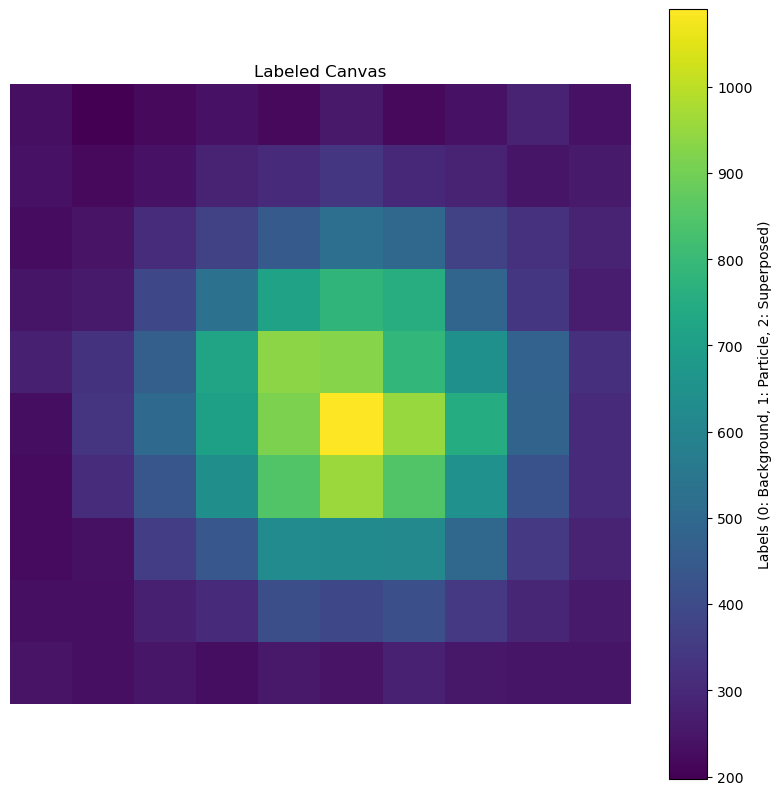

In [97]:
image = plt.imread(image_path)
plt.figure(figsize=(10, 10))
plt.title("Labeled Canvas")
plt.imshow(image[580:590,510:520] , cmap='viridis')
plt.colorbar(label="Labels (0: Background, 1: Particle, 2: Superposed)")
plt.axis('off')
plt.show()